In [ ]:
# Importing libraries
from keras.datasets.mnist import load_data
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Conv2DTranspose, Reshape
from keras.utils import plot_model
import numpy as np
import os

In [ ]:
# Loading data
(x_train, y_train), (x_test, y_test) = load_data()

# Reshape and normalize dataset
x_train = np.expand_dims(x_train, axis=-1).astype('float32')

# Normalize to [-1, 1]
x_train = (x_train - 127.5) / 127.5

print(x_train.shape)
print(y_train.shape)

(60000, 28, 28, 1)
(60000,)


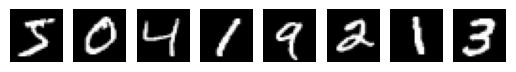

In [ ]:
# Display some images
for i in range(8):
    plt.subplot(1, 8, 1 + i)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')
plt.show()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521,345 (1.99 MB)

 Trainable params: 521,345 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

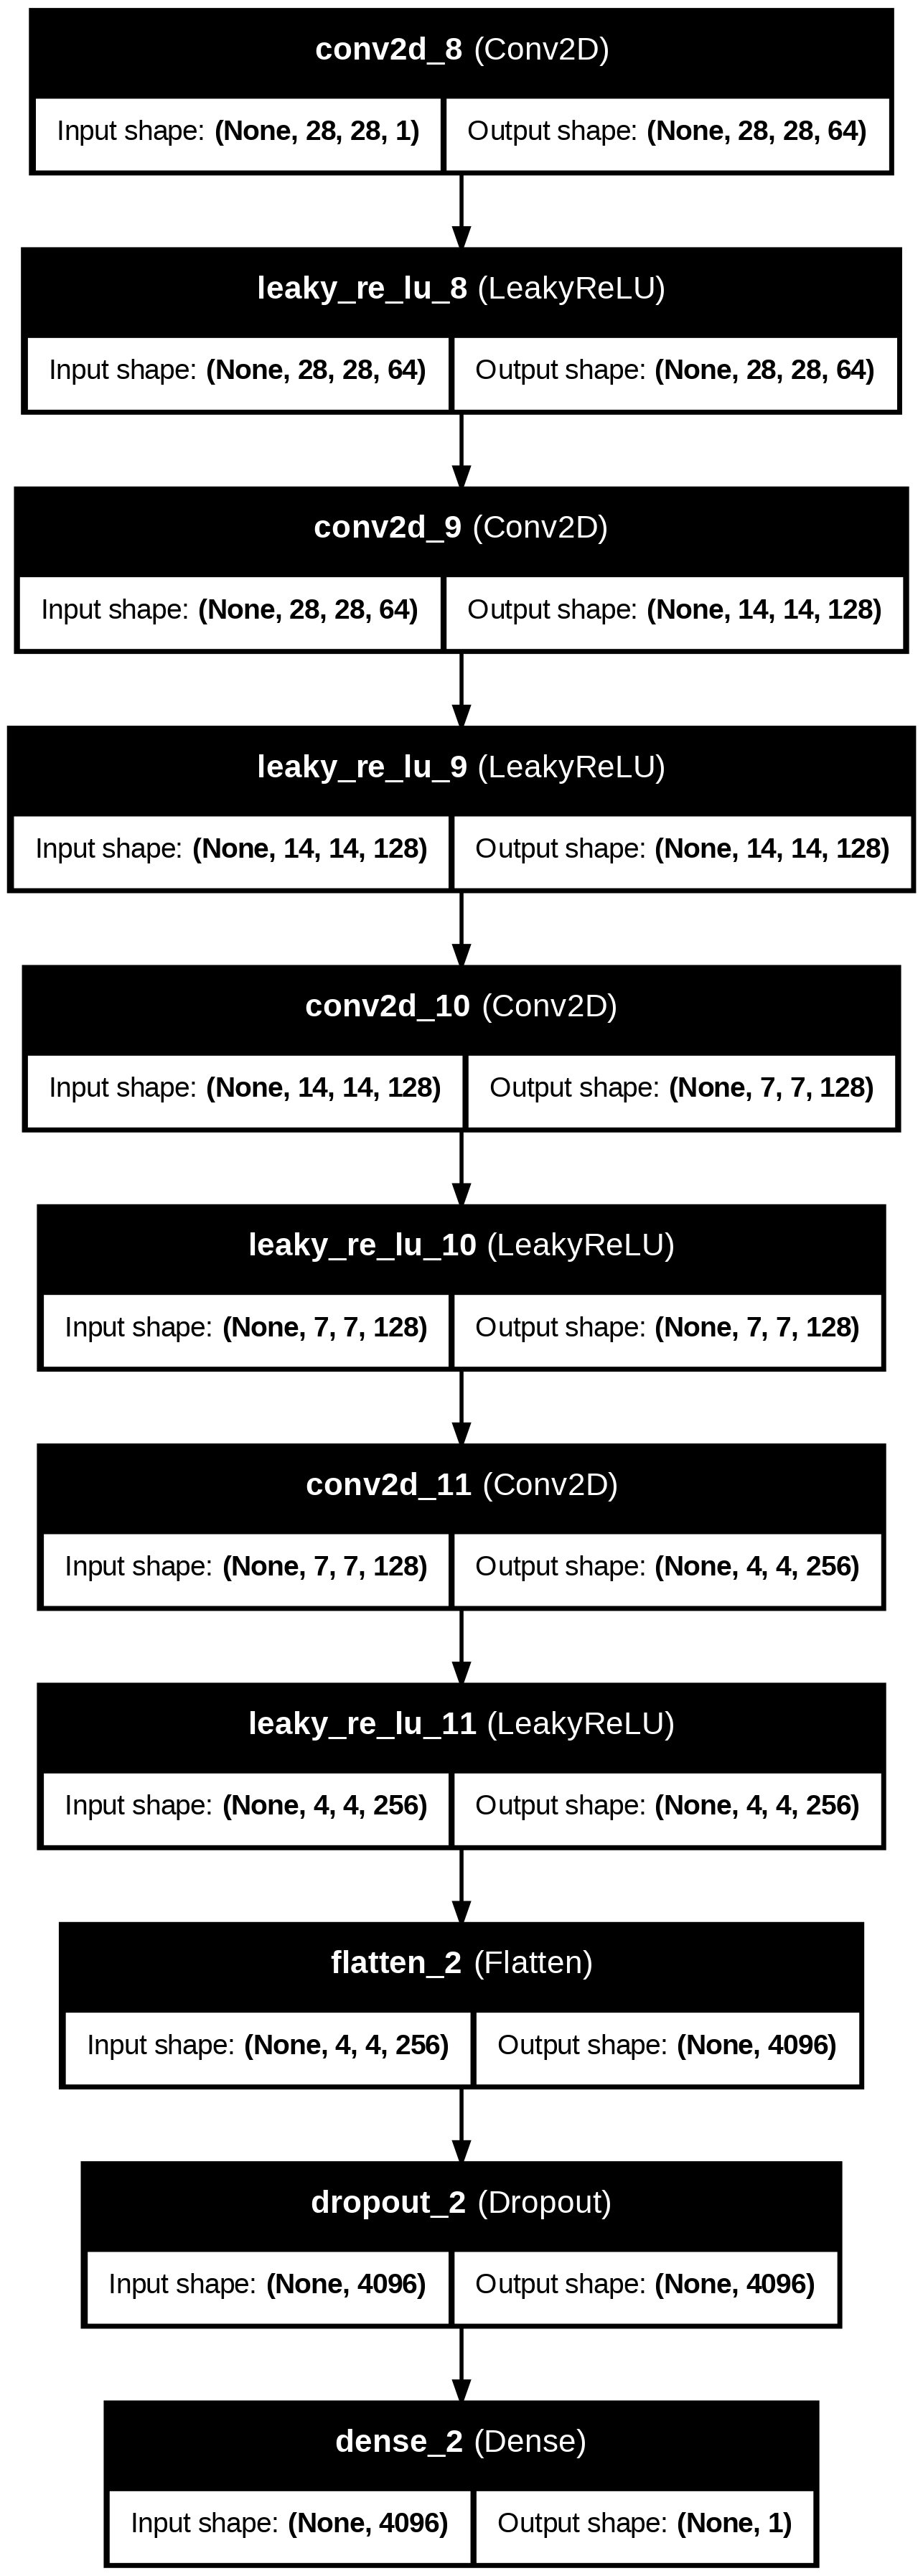

In [ ]:
# Defining Discriminator, near 0 = fake, near 1 = real
def define_discriminator(in_shape=(28, 28, 1)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model = define_discriminator()
model.summary()
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Generating real data samples
def load_real_sample():
    (x_train, _), (_, _) = load_data()
    x = x_train.astype('float32')
    x = (x - 127.5) / 127.5
    return x

X = load_real_sample()
print(X.shape)

def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    x = dataset[ix]
    x = np.expand_dims(x, axis=-1)
    y = np.ones((n_samples, 1))
    return x, y

real_x, real_y = generate_real_samples(X, 64)
print(real_x.shape)
print(real_y.shape)

(60000, 28, 28)
(64, 28, 28, 1)
(64, 1)


(64, 28, 28, 1)
(64, 1)


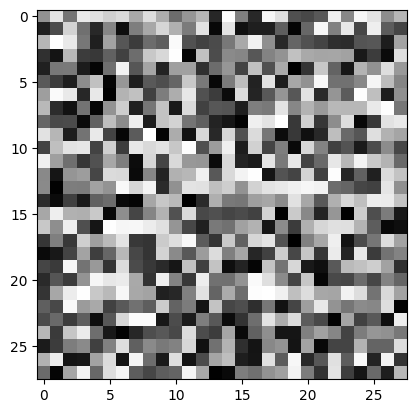

In [ ]:
# Generating fake data samples
def generate_fake_samples(n_samples):
    x = np.random.rand(n_samples, 28, 28, 1)
    x = -1 + x * 2
    y = np.zeros((n_samples, 1))
    return x, y

fake_x, fake_y = generate_fake_samples(64)
print(fake_x.shape)
print(fake_y.shape)
plt.imshow(fake_x[0], cmap='gray')
plt.show()

In [ ]:
# Training the discriminator
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
    half_batch = int(n_batch / 2)
    for i in range(n_iter):
        x_real, y_real = generate_real_samples(dataset, half_batch)
        _, real_acc = model.train_on_batch(x_real, y_real)

        x_fake, y_fake = generate_fake_samples(half_batch)
        _, fake_acc = model.train_on_batch(x_fake, y_fake)

        print(">%d real=%.0f%% fake=%.0f%%" % (i + 1, real_acc * 100, fake_acc * 100))

model = define_discriminator()
dataset = load_real_sample()
train_discriminator(model, dataset)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


>1 real=22% fake=16%
>2 real=44% fake=40%
>3 real=52% fake=52%
>4 real=59% fake=62%
>5 real=66% fake=70%
>6 real=72% fake=75%
>7 real=77% fake=78%
>8 real=80% fake=81%
>9 real=82% fake=83%
>10 real=84% fake=85%
>11 real=85% fake=86%
>12 real=87% fake=87%
>13 real=88% fake=88%
>14 real=89% fake=89%
>15 real=89% fake=90%
>16 real=90% fake=90%
>17 real=91% fake=91%
>18 real=91% fake=92%
>19 real=92% fake=92%
>20 real=92% fake=92%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 12544)          │     1,266,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 1)      │         1,153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,054,785 (7.84 MB)

 Trainable params: 2,054,785 (7.84 MB)

 Non-trainable params: 0 (0.00 B)

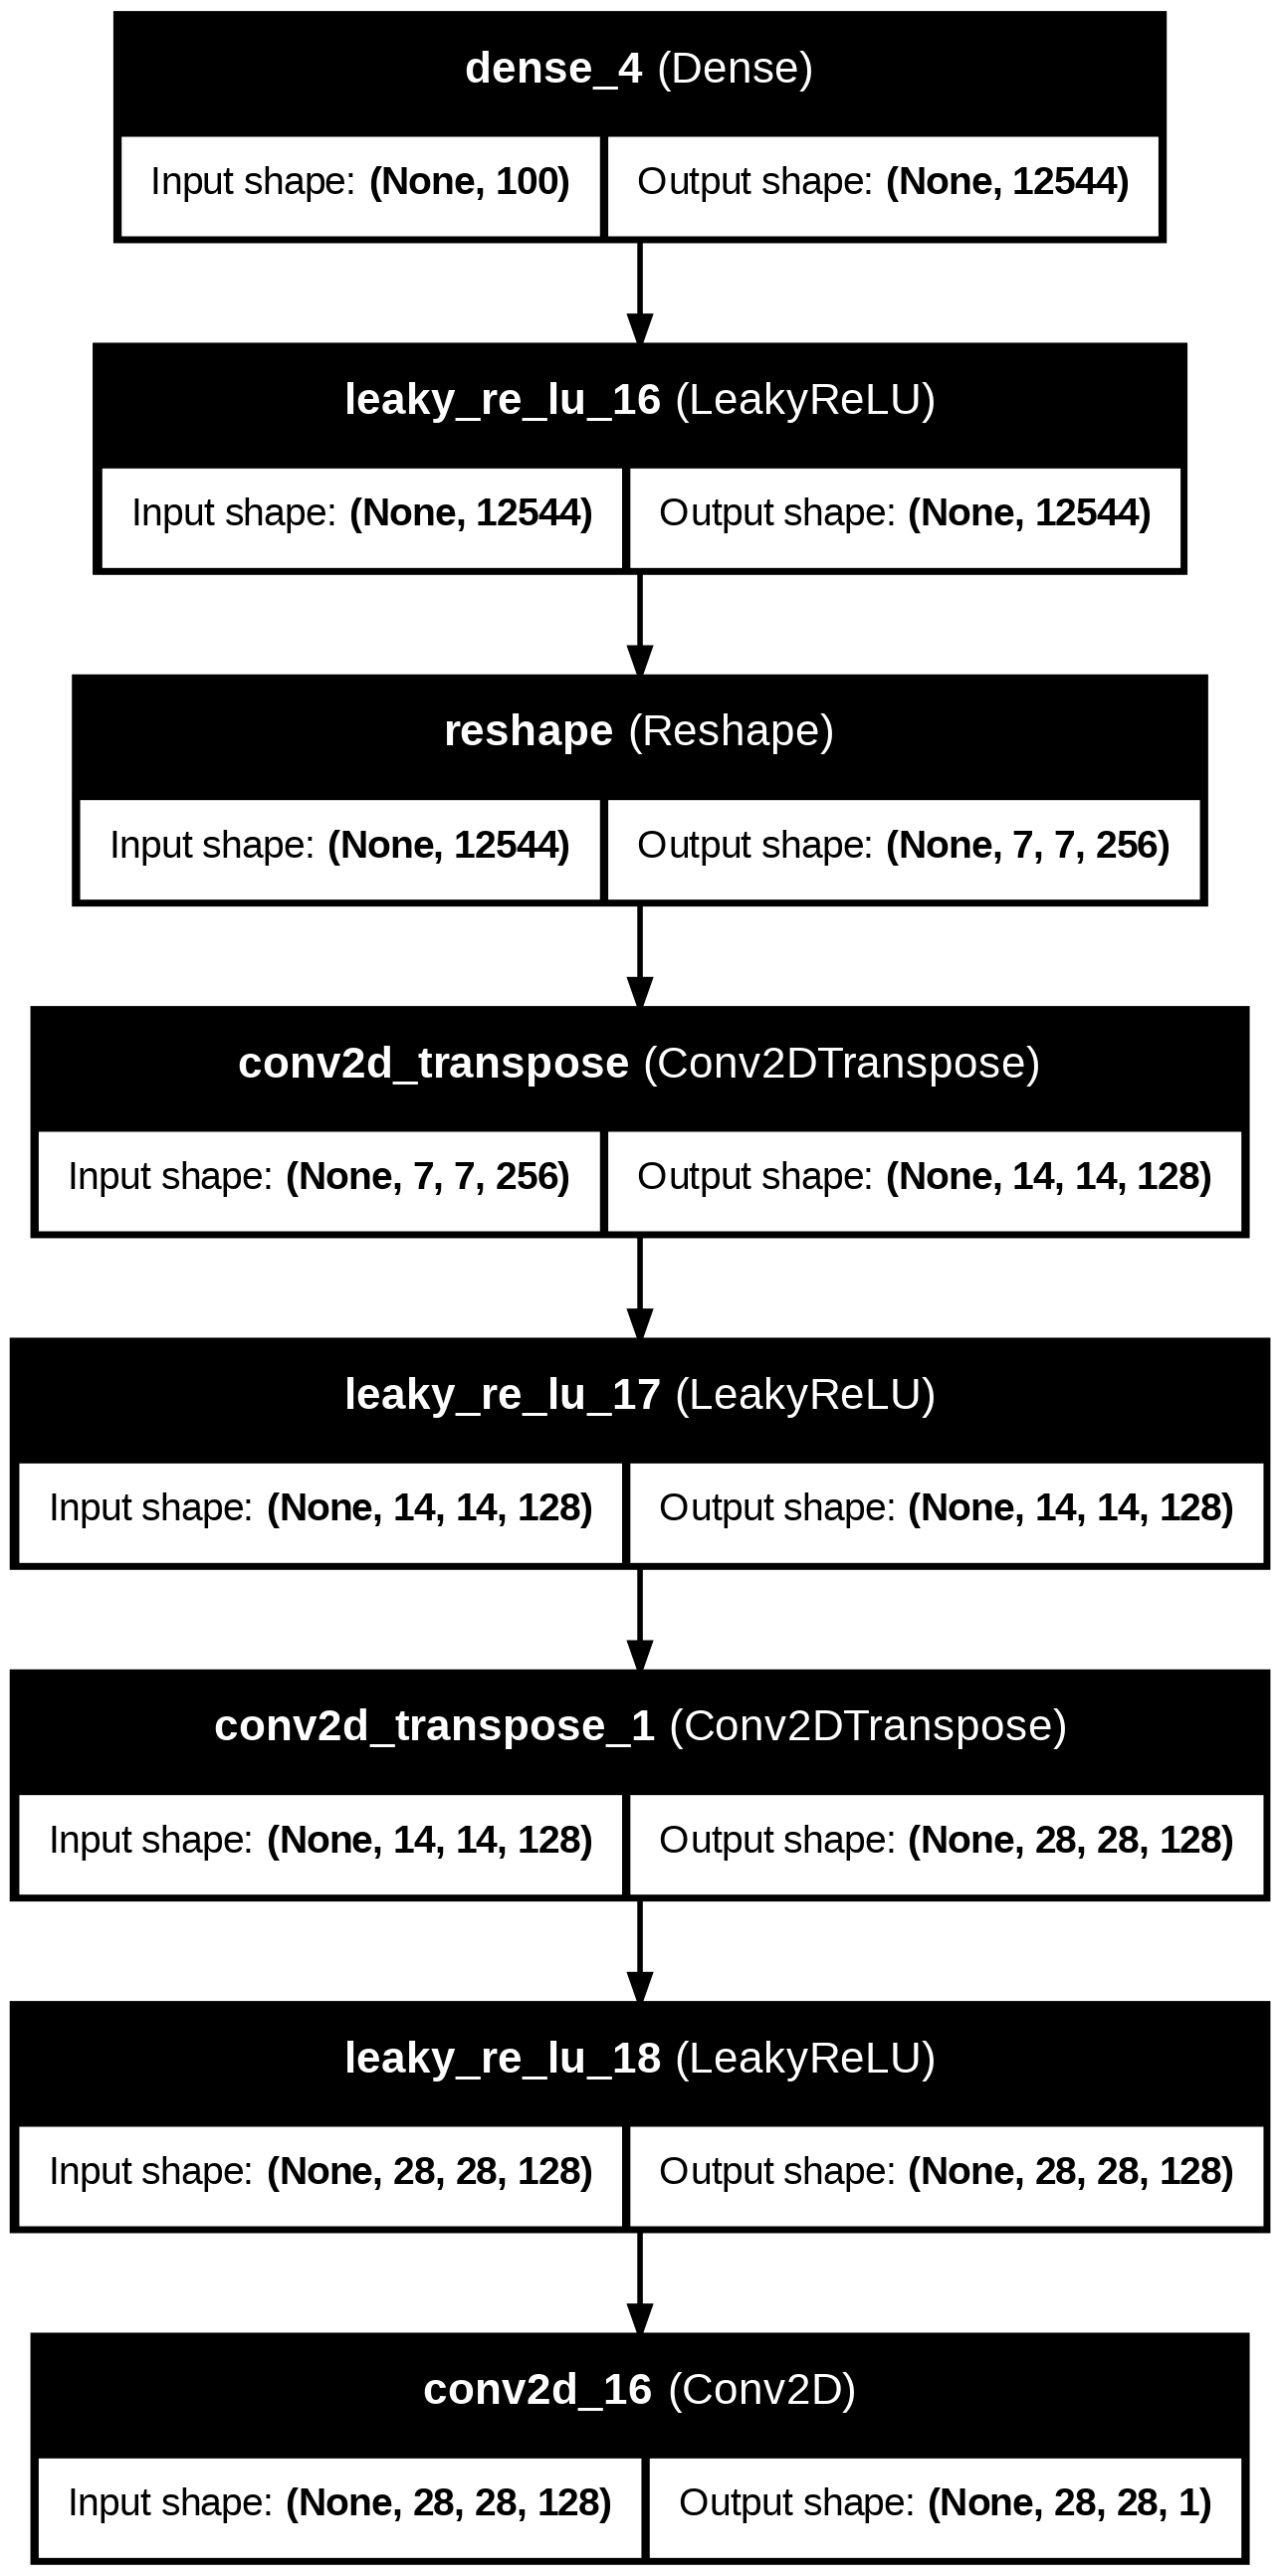

In [ ]:
# Defining Generator Model
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 7 * 7 * 256
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (3, 3), activation='tanh', padding='same'))
    return model

generator_model = define_generator(latent_dim=100)
generator_model.summary()
plot_model(generator_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Creating latent points
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

x_input = generate_latent_points(100, 64)
print(x_input.shape)
print(x_input[0])
print(len(x_input[0]))

(64, 100)
[ 0.53911751 -0.66101893 -0.21773472  1.43282318 -1.17375054  0.56091294
 -0.38894354  2.2211557  -0.69332298 -0.71425204  2.11568441 -0.67048144
 -0.39965873 -0.12049254  1.00566978  0.05913029  0.14571148  1.44348443
 -1.07999227 -0.33933836 -0.06915321  0.57969277 -0.97275874 -1.16319036
  0.25053136  0.48715985 -0.12425481  1.3914555   0.40791248  0.69244911
 -0.85988163  0.1616457   0.83213022 -0.12895925 -0.49906311 -2.18219917
 -1.16286725 -0.31799022  1.06778722  1.41433238  1.11864735 -0.70565081
 -0.5687973   0.04945726 -0.07682261 -0.57460791 -1.27630934  1.01872498
  1.02748574 -0.31831197 -1.24476841  0.70758703 -2.14773179  1.10101111
 -1.43383935 -1.89784514  0.37214583 -0.82744981  0.67352481 -0.03460694
  0.64219593  0.06301448  0.63201836 -0.77453174 -0.52043999  1.21431593
 -0.39462786  1.27517051  0.3300634   0.63715368 -0.81136774 -0.82137976
  1.53592259  0.06462484  1.39342158 -0.4031998  -1.7105054  -0.5725641
  0.50581337 -0.94552426 -0.19883038 -0.56

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


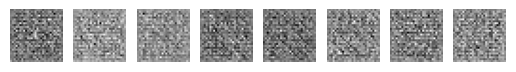

In [ ]:
# Generating fake samples using generator
def generate_fake_samples(generator_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    x = generator_model.predict(x_input)
    y = np.zeros((n_samples, 1))
    return x, y

latent_dim = 100
generator_model = define_generator(latent_dim)
n_samples = 8
x, _ = generate_fake_samples(generator_model, latent_dim, n_samples)
x = (x + 1) / 2.0

for i in range(8):
    plt.subplot(1, 8, 1 + i)
    plt.imshow(x[i], cmap='gray')
    plt.axis('off')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 28, 28, 1)      │     2,054,785 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 1)              │       521,345 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,576,130 (9.83 MB)

 Trainable params: 2,054,785 (7.84 MB)

 Non-trainable params: 521,345 (1.99 MB)

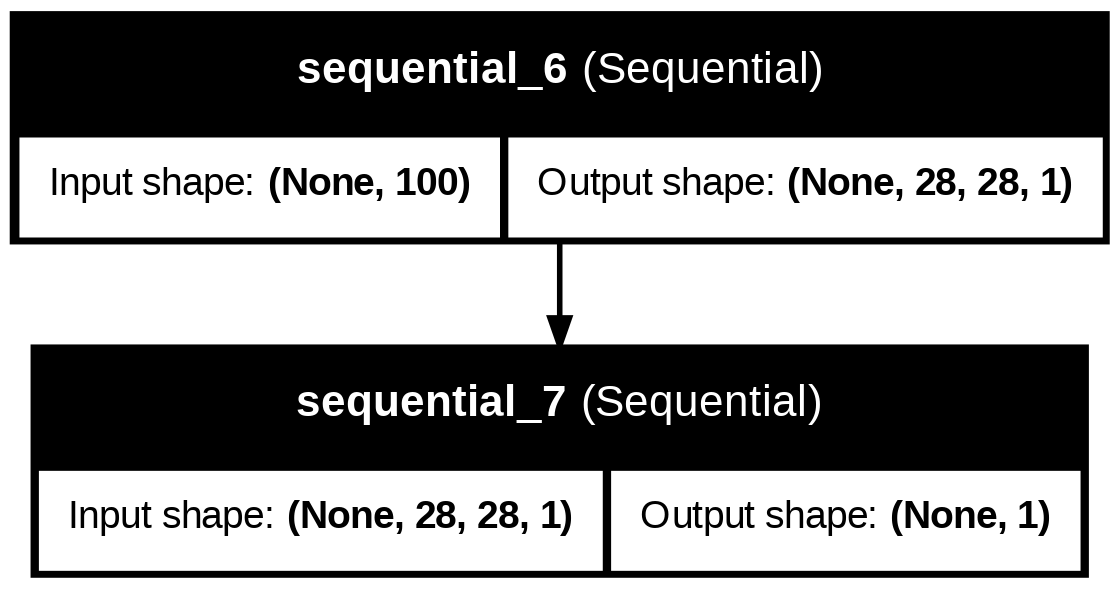

In [ ]:
# GAN Model
def define_gan(generator_model, discriminator_model):
    discriminator_model.trainable = False
    model = Sequential()
    model.add(generator_model)
    model.add(discriminator_model)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

generator_model = define_generator(latent_dim)
discriminator_model = define_discriminator()
gan_model = define_gan(generator_model, discriminator_model)
gan_model.summary()
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Training loop
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        for j in range(bat_per_epo):
            x_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(x_real, y_real)

            x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(x_fake, y_fake)

            x_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(x_gan, y_gan)

            print("epoch:%d, batch:%d/%d, real_loss:%.3f, fake_loss:%.3f, gan_loss=%.3f" %
                  (i + 1, j + 1, bat_per_epo, d_loss1, d_loss2, g_loss))

        if (i + 1) in [5, 10]:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
# Performance summary
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    x_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(x_real, y_real, verbose=0)

    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    print(">>>> Accuracy real: %.0f%%, fake: %.0f%%" % (acc_real * 100, acc_fake * 100))
    save_plot(x_fake, epoch)

    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

In [ ]:
# Saving generated images
def save_plot(examples, epoch, n=7):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.imshow(examples[i], cmap='gray')
        plt.axis('off')
    plt.show()
    filename = 'generator_model_%03d.png' % (epoch + 1)
    plt.savefig(filename)
    plt.close()

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step
epoch:1, batch:1/468, real_loss:0.701, fake_loss:0.697, gan_loss=0.693
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
epoch:1, batch:2/468, real_loss:0.701, fake_loss:0.699, gan_loss=0.693
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
epoch:1, batch:3/468, real_loss:0.700, fake_loss:0.699, gan_loss=0.693
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
epoch:1, batch:4/468, real_loss:0.699, fake_loss:0.698, gan_loss=0.693
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
epoch:1, batch:5/468, real_loss:0.699, fake_loss:0.698, gan_loss=0.693
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
epoch:1, batch:6/468, real_loss:0.699, fake_loss:0.699, gan_loss=0.692
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
epoch:1, batch:7/468, real_loss:0.699, fake_loss:0.699, gan_loss=0.692
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
epoch:1, batch:8/468, real_loss:0.699, fake_loss:0.699, gan_loss=0.692
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
epoch:1, batch:9/468, real_loss:0.699, fake_loss:0.699, gan_loss=0.691
2/2 ━━━━━━

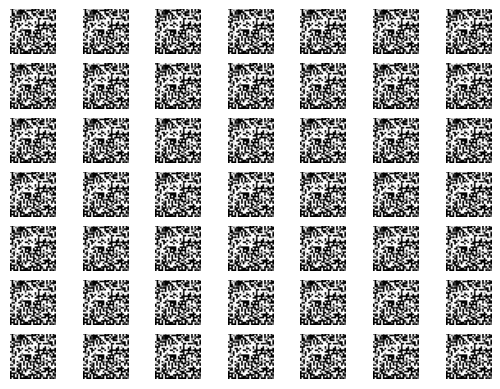

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
epoch:6, batch:1/468, real_loss:0.915, fake_loss:0.936, gan_loss=0.477
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
epoch:6, batch:2/468, real_loss:0.892, fake_loss:0.910, gan_loss=0.477
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
epoch:6, batch:3/468, real_loss:0.882, fake_loss:0.897, gan_loss=0.477
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
epoch:6, batch:4/468, real_loss:0.876, fake_loss:0.889, gan_loss=0.477
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
epoch:6, batch:5/468, real_loss:0.873, fake_loss:0.883, gan_loss=0.477
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
epoch:6, batch:6/468, real_loss:0.870, fake_loss:0.880, gan_loss=0.477
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
epoch:6, batch:7/468, real_loss:0.868, fake_loss:0.876, gan_loss=0.477
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
epoch:6, batch:8/468, real_loss:0.866, fake_loss:0.874, gan_loss=0.477
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
epoch:6, batch:9/468, real_loss:0.865, fake_loss:0.872, gan_loss=0.477
2/2 ━━━━━━

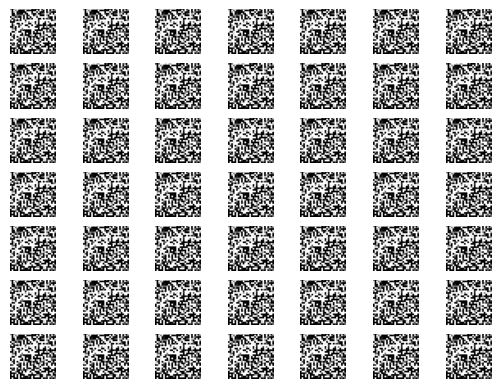

In [ ]:
# Run training
train(generator_model, discriminator_model, gan_model, dataset, latent_dim=100, n_epochs=10, n_batch=128)